# PheWAS analysis

Check if there are associations of phenotypes with circadian problems,
particularly for unusual timing or for lack of consistent rhythm.

In [2]:
%matplotlib notebook
import scipy
import numpy
from IPython.display import display, HTML
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import re
import matplotlib.patches as mpatches
from scipy.cluster import hierarchy
import pylab
import pandas

In [3]:
COHORT = 1
OUTDIR = f"../phewas/cohort{COHORT}/"

In [4]:
full_activity = pandas.read_csv("../processed/activity_features_aggregate.txt", index_col=0, sep="\t")
activity_summary = pandas.read_csv("../processed/activity_summary_aggregate.txt", index_col=0, sep="\t")
ukbb = pandas.read_hdf("../processed/ukbb_data_table.h5")

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (816) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
ukbb.columns = ukbb.columns.str.replace("[,:/]","_") # Can't use special characters easily

In [34]:
# Remove the activity variables that we don't want to use
bad_columns = ["_IV$", "^temp_", "^light_"]
good_columns = []
for c in full_activity.columns:
    fail = False
    for bad in bad_columns:
        if re.search(bad, c):
            fail = True
    if not fail:
        good_columns.append(c)
activity = full_activity[good_columns]

In [33]:
# drop activity for people who fail basic QC
[c for c in activity_summary.columns if 'quality' in c]
okay = (activity_summary['quality-goodCalibration'].astype(bool)
            & (~activity_summary['quality-daylightSavingsCrossover'].astype(bool))
            & (activity_summary['quality-goodWearTime'].astype(bool))
       )
activity = activity[okay]
activity.columns = activity.columns.str.replace("-","_") # Can't use special characters easily
print(f"Dropping {(~okay).sum()} entries out of {len(okay)} due to bad quality or wear-time")

Dropping 11363 entries out of 103688 due to bad quality or wear-time


c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [32]:
covariates = [
              "sex", "ethnicity", "overall_health", "household_income", "smoking", "birth_year", "BMI",
               #'education_Prefer_not_to_answer', # This answer causes problems for some reason
               'education_None_of_the_above',
               'education_College_or_University_degree',
               'education_A_levels_AS_levels_or_equivalent', 
               'education_O_levels_GCSEs_or_equivalent',
               'education_CSEs_or_equivalent',
               'education_NVQ_or_HND_or_HNC_or_equivalent',
               'education_Other_professional_qualifications_eg__nursing__teaching',
                ]

data_full = activity.copy()
data_full = data_full.join(ukbb[covariates], how="inner")
print(f"Data starting size: {data_full.shape}")

# Down sample for testing
numpy.random.seed(0)
# Note: total 92331, half is 46164
cohort_id_ranges = {1: slice(0, 25000),
           2: slice(25000,50000)}
selected_ids = numpy.random.choice(data_full.index, size=data_full.shape[0], replace=False)[cohort_id_ranges[COHORT]]
data = data_full.loc[selected_ids].copy()
print(f"Data size after selecting test set: {data.shape}")

Data starting size: (92325, 74)
Data size after selecting test set: (25000, 74)


In [11]:
activity.columns

Index(['main_sleep_onset_avg', 'main_sleep_offset_avg', 'num_wakings_avg',
       'WASO_avg', 'acceleration_during_main_sleep_avg', 'sleep_peak_time_avg',
       'sleep_peak_quality_avg', 'other_sleep_avg', 'main_sleep_duration_avg',
       'total_sleep_avg', 'main_sleep_ratio_avg', 'walking_peak_time_avg',
       'walking_peak_value_avg', 'sedentary_peak_time_avg',
       'sedentary_peak_value_avg', 'moderate_peak_time_avg',
       'moderate_peak_value_avg', 'acceleration_peak_time_avg',
       'acceleration_peak_value_avg', 'tasks_light_peak_time_avg',
       'tasks_light_peak_value_avg', 'MET_peak_time_avg', 'MET_peak_value_avg',
       'main_sleep_onset_std', 'main_sleep_offset_std', 'num_wakings_std',
       'WASO_std', 'acceleration_during_main_sleep_std', 'sleep_peak_time_std',
       'sleep_peak_quality_std', 'other_sleep_std', 'main_sleep_duration_std',
       'total_sleep_std', 'main_sleep_ratio_std', 'walking_peak_time_std',
       'walking_peak_value_std', 'sedentary_peak_t

In [12]:
# Q-value utility
def BH_FDR(ps):
    ''' Benjamini-Hochberg FDR control

    Converts p values to q values'''

    # For the purposes of comparison, an implementation of Benjamini Hochberg correction
    sort_order = numpy.argsort(ps)

    adjusted = numpy.zeros(ps.shape)
    adjusted[sort_order] = numpy.array(ps)[sort_order]*len(ps)/numpy.arange(1,len(ps)+1)

    # Make monotone, skipping NaNs
    m = 1;
    for i, r in enumerate(sort_order[::-1]):
        if numpy.isfinite(adjusted[r]):
            m = min(adjusted[r], m)
            adjusted[r] = m

    return adjusted # the q-values

## Load the ICD10/9 code data

In [13]:
icd10_entries_all = pandas.read_csv("../processed/ukbb_icd10_entries.txt", sep="\t")
# Select our cohort from all the entries
icd10_entries = icd10_entries_all[icd10_entries_all.ID.isin(selected_ids)].copy()
icd10_entries.rename(columns={"ICD10_code": "ICD10"}, inplace=True)

In [14]:
# Load the PheCode mappings
# Downloaded from https://phewascatalog.org/phecodes_icd10
# Has columns:
# ICD10 | PHECODE | Exl. Phecodes | Excl. Phenotypes
phecode_info = pandas.read_csv("../phecode_definitions1.2.csv", index_col=0)
#phecode_map = pandas.read_csv("../Phecode_map_v1_2_icd10_beta.csv")
#phecode_map['ICD10'] = phecode_map['ICD10'].str.replace(".","") # Remove dots to match UKBB-style ICD10s
phecode_map = pandas.read_csv("../Phecode_map_v1_2_icd10_beta.csv")
phecode_map.set_index(phecode_map.ICD10.str.replace(".",""), inplace=True) # Remove '.' to match UKBB-style ICD10 codes

In [15]:
### and the ICD9 data
icd9_entries_all = pandas.read_csv("../processed/ukbb_icd9_entries.txt", sep="\t")
# Select our cohort from all the entries
icd9_entries = icd9_entries_all[icd9_entries_all.ID.isin(selected_ids)].copy()
icd9_entries.rename(columns={"ICD9_code": "ICD9"}, inplace=True)

In [16]:
# and conver to phecodes
# v1.2 Downloaded from https://phewascatalog.org/phecodes
phecode_map_icd9 = pandas.read_csv("../phecode_icd9_map_unrolled.csv")
phecode_map_icd9.rename(columns={"icd9":"ICD9", "phecode":"PHECODE"}, inplace=True)
phecode_map_icd9.set_index( phecode_map_icd9['ICD9'].str.replace(".",""), inplace=True) # Remove dots to match UKBB-style ICD9s

In [17]:
# Self-reported conditions from the interview stage of the UK Biobank
self_reported_all = pandas.read_csv("../processed/ukbb_self_reported_conditions.txt", sep="\t", dtype={"condition_code":int})
self_reported = self_reported_all[self_reported_all.ID.isin(selected_ids)].copy()
data_fields = pandas.read_csv("../Data_Dictionary_Showcase.csv", index_col="FieldID")
codings = pandas.read_csv("../Codings_Showcase.csv", dtype={"Coding": int})
SELF_REPORTED_CONDITION_FIELD = 20002
condition_code_to_meaning = codings[codings.Coding  == data_fields.loc[20002].Coding].drop_duplicates(subset=["Value"], keep=False).set_index("Value")
self_reported["condition"] = self_reported.condition_code.astype(str).map(condition_code_to_meaning.Meaning)

# Investigate "block"-level subcategories of ICD10 codes

CURRENTLY DISABLED SINCE WE USE PheCODEs INSTEAD

# Investigate the tails of the distribution

# Run a PheCode-based analysis

In [18]:
# Convert self-reported conditions to phecodes

# Load Manaully mapped self-reports to phecodes
self_report_phecode_map = pandas.read_csv("../self_report_conditions_meanings.txt", sep="\t", index_col=0)
self_reported["phecode"] = self_reported.condition_code.map(self_report_phecode_map['PheCODE'])

In [19]:
# Gather whether each person has a diagnosis from a given PheCode group

# Group phecodes together that differ only after the '.'
# i.e. if they convert to the same integer
phecode_groups = phecode_info.index.astype(int).unique()

phecode_data_icd10 = {}
phecode_data_icd9 = {}
phecode_data_self_report = {}
for group in phecode_groups:
    group_data = phecode_info[phecode_info.index.astype(int) == group]
    icd10_codes = phecode_map[phecode_map.PHECODE.isin(group_data.index)].index
    icd9_codes = phecode_map_icd9[phecode_map_icd9.PHECODE.isin(group_data.index)].index
    in_block = icd10_entries.ICD10.isin(icd10_codes)
    in_block_icd9 = icd9_entries.ICD9.isin(icd9_codes)
    
    diagnosed = in_block.groupby(icd10_entries.ID).any()
    phecode_data_icd10[group] = diagnosed
    phecode_data_icd9[group] =  in_block_icd9.groupby(icd9_entries.ID).any()
    phecode_data_self_report[group] = self_reported.phecode.isin(group_data.index)

phecode_data_icd10 = pandas.DataFrame(phecode_data_icd10)
phecode_data_icd9 = pandas.DataFrame(phecode_data_icd9)
phecode_data_self_report = pandas.DataFrame(phecode_data_self_report).set_index(self_reported.ID)
phecode_data = pandas.concat([phecode_data_icd10, phecode_data_icd9, phecode_data_self_report]).reset_index().groupby(by="ID").any()

### Display which sources the cases come from for the top codes

In [20]:
phecode_counts = pandas.DataFrame({"counts": phecode_data.sum(axis=0)})
for name, d in {"icd10": phecode_data_icd10, "icd9": phecode_data_icd9, "self_report": phecode_data_self_report}.items():
    cases = d.reset_index().groupby(by="ID").any()
    phecode_counts[name + "_cases"] = cases.sum(axis=0)
phecode_counts["meaning"] = phecode_counts.index.map(phecode_info.phenotype)
phecode_counts.sort_values(by="counts", ascending=False).head(30)

,counts,icd10_cases,icd9_cases,self_report_cases,meaning
401,6915,4406,5,5570,Hypertension
272,3759,2003,1,2609,Disorders of lipoid metabolism
495,3120,1594,3,2782,Asthma
550,3100,2863,32,619,Abdominal hernia
740,2820,1330,5,1936,Osteoarthrosis
530,2738,2185,6,973,Diseases of esophagus
785,2403,2359,51,0,Abdominal pain
562,1869,1779,2,221,Diverticulosis and diverticulitis
564,1793,1400,7,512,Functional digestive disorders
306,1761,1759,2,0,Other mental disorder


In [21]:
phecode_counts.sum()

counts               140576
icd10_cases          113866
icd9_cases             1534
self_report_cases     37577
dtype: int64

In [17]:
# Correlate each block-level code with our activity variable
activity_variable = "acceleration_RA"

phecode_tests = {}

phecode_ols_data = data.copy()

covariate_formula = ' + '.join(c for c in covariates if c != 'sex')

for group in phecode_groups:
    
    # Note that those without any ICD10 entries at all should be marked as non-case, hence the fillna()
    phecode_ols_data[group] = phecode_ols_data.index.map(phecode_data[group].astype(int)).fillna(0)
    
    N = phecode_ols_data.dropna(how="any")[group].sum()
    if N == 0:
        print(f"Skipping {group} - no cases found")
        continue
    
    fit = smf.ols(f"acceleration_RA ~ Q({group}) + sex * ({covariate_formula})",
                 data=phecode_ols_data).fit()
    reduced_fit = smf.ols(f"acceleration_RA ~ sex * ({covariate_formula})",
                        data=phecode_ols_data).fit()
    f,p,df = fit.compare_f_test(reduced_fit)
    coeff = fit.params[f"Q({group})"]
    std_effect = coeff / phecode_ols_data['acceleration_RA'].std()
    phecode_tests[group] = {"p": p,
                            "coeff": coeff,
                            "std_effect": std_effect,
                            "N": N,
                           }
phecode_tests = pandas.DataFrame(phecode_tests).T

Skipping 31 - no cases found
Skipping 1003 - no cases found
Skipping 196 - no cases found
Skipping 209 - no cases found
Skipping 249 - no cases found
Skipping 254 - no cases found
Skipping 264 - no cases found
Skipping 453 - no cases found
Skipping 498 - no cases found
Skipping 637 - no cases found
Skipping 657 - no cases found
Skipping 658 - no cases found
Skipping 712 - no cases found
Skipping 763 - no cases found
Skipping 767 - no cases found
Skipping 769 - no cases found
Skipping 795 - no cases found
Skipping 796 - no cases found
Skipping 799 - no cases found
Skipping 816 - no cases found
Skipping 823 - no cases found
Skipping 855 - no cases found
Skipping 856 - no cases found
Skipping 875 - no cases found
Skipping 876 - no cases found
Skipping 905 - no cases found
Skipping 906 - no cases found
Skipping 908 - no cases found
Skipping 909 - no cases found
Skipping 911 - no cases found
Skipping 912 - no cases found
Skipping 931 - no cases found
Skipping 942 - no cases found
Skipping 9

In [18]:
data['education_College_or_University_degree']

3901068    1.0
2525607    0.0
3104792    1.0
5169499    1.0
5011619    0.0
          ... 
5919632    0.0
1944258    1.0
1749694    0.0
2998853    1.0
1310579    1.0
Name: education_College_or_University_degree, Length: 25000, dtype: float64

In [19]:
phecode_tests['q'] = BH_FDR(phecode_tests.p)
phecode_tests["meaning"] = phecode_tests.index.map(phecode_info.phenotype)
phecode_tests["category"] = phecode_tests.index.map(phecode_info.category)
phecode_tests.index.rename("phecode", inplace=True)
phecode_tests.sort_values(by="p")

,p,coeff,std_effect,N,q,meaning,category
phecode,,,,,,,
250,4.575330e-29,-0.021705,-0.317659,1256.0,2.511856e-26,Diabetes mellitus,endocrine/metabolic
276,3.290805e-19,-0.030563,-0.447300,360.0,9.033259e-17,"Disorders of fluid, electrolyte, and acid-base...",endocrine/metabolic
401,2.901276e-16,-0.008143,-0.119169,6813.0,5.309335e-14,Hypertension,circulatory system
585,1.352327e-15,-0.027609,-0.404054,352.0,1.856069e-13,Renal failure,genitourinary
292,1.108738e-13,-0.033338,-0.487901,202.0,1.217394e-11,Neurological disorders,mental disorders
563,1.660903e-13,-0.019760,-0.289187,584.0,1.449079e-11,Constipation,digestive
459,1.847641e-13,-0.016510,-0.241620,858.0,1.449079e-11,Other disorders of circulatory system,circulatory system
290,2.290372e-13,-0.059829,-0.875600,60.0,1.555829e-11,Delirium dementia and amnestic and other cogni...,mental disorders
789,2.550540e-13,-0.019608,-0.286961,583.0,1.555829e-11,Nausea and vomiting,symptoms


In [20]:
phecode_tests[phecode_tests.meaning == "Human immunodeficiency virus [HIV] disease"]

,p,coeff,std_effect,N,q,meaning,category
phecode,,,,,,,
71,0.501079,-0.010506,-0.153762,17.0,0.696437,Human immunodeficiency virus [HIV] disease,infectious diseases


In [21]:
phecode_tests.to_csv(OUTDIR+f"{activity_variable}.phecodes.txt", sep="\t")

Of 549 tested, approx 218 expected non-null
and 57 exceed the Bonferonni significance threshold


<IPython.core.display.Javascript object>


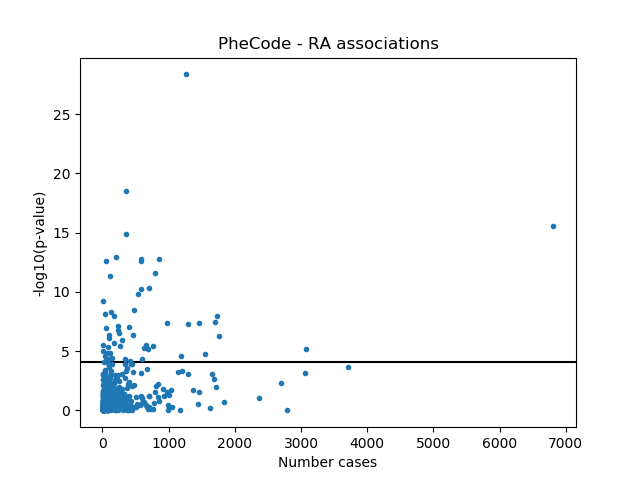

In [22]:
# Summarize the phecode test results
num_nonnull = len(phecode_tests) - phecode_tests.p.sum()*2
bonferonni_cutoff = 0.05 / len(phecode_tests)
print(f"Of {len(phecode_tests)} tested, approx {int(num_nonnull)} expected non-null")
print(f"and {(phecode_tests.p < bonferonni_cutoff).sum()} exceed the Bonferonni significance threshold")

fig, ax = pylab.subplots()

ax.scatter(phecode_tests.N, -numpy.log10(phecode_tests.p), marker=".")
ax.set_xlabel("Number cases")
ax.set_ylabel("-log10(p-value)")
ax.axhline( -numpy.log10(0.05/len(phecode_tests)), c="k", zorder = -1 )
ax.set_title("PheCode - RA associations")
fig.savefig(OUTDIR+"phewas_summary.png")

<IPython.core.display.Javascript object>


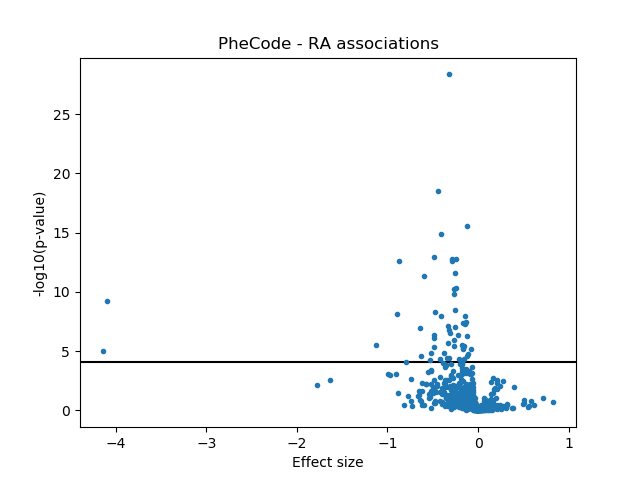

In [23]:
fig, ax = pylab.subplots()

ax.scatter(phecode_tests.std_effect, -numpy.log10(phecode_tests.p), marker=".")
ax.set_xlabel("Effect size")
ax.set_ylabel("-log10(p-value)")
ax.axhline( -numpy.log10(0.05/len(phecode_tests)), c="k", zorder = -1 )
ax.set_title("PheCode - RA associations")
fig.savefig(OUTDIR+"phewas.volcano_plot.png")

# Test sex differences in RA-diagnosis associations

We are interested in whether there is a difference between male and female susceptibility to
loss of circadian rhythm and differences in the impact of loss of circadian rhythm.

We extract the most significant associations and plot their associations within each sex.

In [24]:
# Correlate each block-level code with our activity variable within each sex
activity_variable = "acceleration_RA"

phecode_tests_by_sex = {}

phecode_ols_data = data.copy()

covariate_formula = ' + '.join(c for c in covariates if c != 'sex')

for group in phecode_groups:
        
    # Note that those without any ICD10 entries at all should be marked as non-case, hence the fillna()
    phecode_ols_data[group] = phecode_ols_data.index.map(phecode_data[group].astype(int)).fillna(0)
    
    N = phecode_ols_data[group].sum()
    N_male = numpy.sum(phecode_ols_data[group].astype(bool) & (phecode_ols_data.sex == "Male"))
    N_female = numpy.sum(phecode_ols_data[group].astype(bool) & (phecode_ols_data.sex == "Female"))
    if N <= 0:
        print(f"Skipping {group} - only {N} cases found")
        continue
        
    if False: #phecode_tests.loc[group, "q"] > 0.01:
        # Skip test, not significant
        print(f"Skipping {group} since q > 0.01")
        continue
    
    #phecode_tests_by_sex[group] = {}
    
    fit = smf.ols(f"acceleration_RA ~ 0 + C(sex, Treatment(reference=-1)) : ({covariate_formula} +  Q({group}))",
                     data=phecode_ols_data).fit()


    female_coeff = fit.params[f'C(sex, Treatment(reference=-1))[Female]:Q({group})']
    male_coeff = fit.params[f'C(sex, Treatment(reference=-1))[Male]:Q({group})']
    p_female = fit.pvalues[f'C(sex, Treatment(reference=-1))[Female]:Q({group})']
    p_male = fit.pvalues[f'C(sex, Treatment(reference=-1))[Male]:Q({group})']
    diff_test = fit.t_test(f'C(sex, Treatment(reference=-1))[Male]:Q({group}) = C(sex, Treatment(reference=-1))[Female]:Q({group})')
    p_diff = diff_test.pvalue
    conf_ints = fit.conf_int()
    male_conf_int = conf_ints.loc[f'C(sex, Treatment(reference=-1))[Male]:Q({group})']
    female_conf_int = conf_ints.loc[f'C(sex, Treatment(reference=-1))[Female]:Q({group})']
    
    phecode_tests_by_sex[group] = {
        "male_coeff": float(male_coeff),
        "female_coeff": float(female_coeff),
        "p_male": float(p_male),
        "p_female": float(p_female),
        "p_diff": float(p_diff),
        "N_male": N_male,
        "N_female": N_female,
        "male_coeff_low": float(male_conf_int[0]),
        "male_coeff_high": float(male_conf_int[1]),
        "female_coeff_low": float(female_conf_int[0]),
        "female_coeff_high": float(female_conf_int[1]),
    }

phecode_tests_by_sex = pandas.DataFrame(phecode_tests_by_sex).T

Skipping 31 - only 0.0 cases found
Skipping 1003 - only 0.0 cases found


c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Skipping 196 - only 0.0 cases found
Skipping 209 - only 0.0 cases found
Skipping 249 - only 0.0 cases found
Skipping 254 - only 0.0 cases found
Skipping 264 - only 0.0 cases found
Skipping 453 - only 0.0 cases found
Skipping 498 - only 0.0 cases found
Skipping 637 - only 0.0 cases found
Skipping 657 - only 0.0 cases found
Skipping 658 - only 0.0 cases found
Skipping 712 - only 0.0 cases found
Skipping 763 - only 0.0 cases found
Skipping 767 - only 0.0 cases found
Skipping 769 - only 0.0 cases found
Skipping 795 - only 0.0 cases found
Skipping 796 - only 0.0 cases found
Skipping 799 - only 0.0 cases found
Skipping 816 - only 0.0 cases found
Skipping 823 - only 0.0 cases found
Skipping 855 - only 0.0 cases found
Skipping 856 - only 0.0 cases found
Skipping 875 - only 0.0 cases found
Skipping 876 - only 0.0 cases found
Skipping 905 - only 0.0 cases found
Skipping 906 - only 0.0 cases found
Skipping 908 - only 0.0 cases found
Skipping 909 - only 0.0 cases found
Skipping 911 - only 0.0 case

In [25]:
phecode_tests_by_sex["meaning"] = phecode_tests_by_sex.index.map(phecode_info.phenotype)
phecode_tests_by_sex["category"] = phecode_tests_by_sex.index.map(phecode_info.category)
phecode_tests_by_sex = phecode_tests_by_sex.join(phecode_tests.q, how="left")
phecode_tests_by_sex['q_diff'] = BH_FDR(phecode_tests_by_sex.p_diff)

In [26]:
phecode_tests_by_sex.sort_values("p_diff").head(10)

,male_coeff,female_coeff,p_male,p_female,p_diff,N_male,N_female,male_coeff_low,male_coeff_high,female_coeff_low,female_coeff_high,meaning,category,q,q_diff
910,-0.599576,0.039382,6.700256e-21,0.537480,1.545970e-12,1.0,1.0,-0.724773,-0.474378,-0.085798,0.164561,"Superficial injury, infected",injuries & poisonings,2.169613e-08,8.487375e-10
230,-0.283056,0.000000,9.808270e-06,NaN,9.808270e-06,1.0,0.0,-0.408514,-0.157599,0.000000,0.000000,Kaposi's sarcoma,neoplasms,1.223805e-04,2.692370e-03
563,-0.034419,-0.011494,1.215108e-14,0.000599,3.945931e-05,218.0,383.0,-0.043159,-0.025679,-0.018057,-0.004931,Constipation,digestive,1.449079e-11,7.221054e-03
474,-0.023421,0.004229,3.674577e-05,0.357483,1.530238e-04,132.0,197.0,-0.034542,-0.012300,-0.004779,0.013238,Acute and chronic tonsillitis,respiratory,1.592542e-01,1.771361e-02
198,-0.028062,-0.003505,6.554020e-08,0.371566,1.613262e-04,157.0,274.0,-0.038239,-0.017885,-0.011195,0.004184,Secondary malignant neoplasm,neoplasms,7.067332e-04,1.771361e-02
976,0.069855,-0.201712,2.757019e-01,0.000008,5.383308e-04,1.0,2.0,-0.055754,0.195464,-0.290428,-0.112997,Poisoning by agents primarily affecting skin &...,injuries & poisonings,1.507944e-02,4.763715e-02
694,-0.041338,0.009338,1.427893e-04,0.351744,6.110810e-04,36.0,41.0,-0.062638,-0.020037,-0.010317,0.028993,Dyschromia and Vitiligo,dermatologic,1.569141e-01,4.763715e-02
696,0.007602,-0.015612,1.089412e-01,0.001556,6.941661e-04,188.0,172.0,-0.001693,0.016897,-0.025282,-0.005942,Psoriasis and related disorders,dermatologic,5.090401e-01,4.763715e-02
740,0.005816,-0.003325,6.287539e-03,0.050125,7.866878e-04,1059.0,1761.0,0.001644,0.009987,-0.006653,0.000002,Osteoarthrosis,musculoskeletal,9.305529e-01,4.798795e-02
655,0.000000,0.011141,NaN,0.001939,1.938985e-03,0.0,353.0,0.000000,0.000000,0.004096,0.018186,Known or suspected fetal abnormality affecting...,pregnancy complications,1.169783e-02,1.019644e-01


<IPython.core.display.Javascript object>


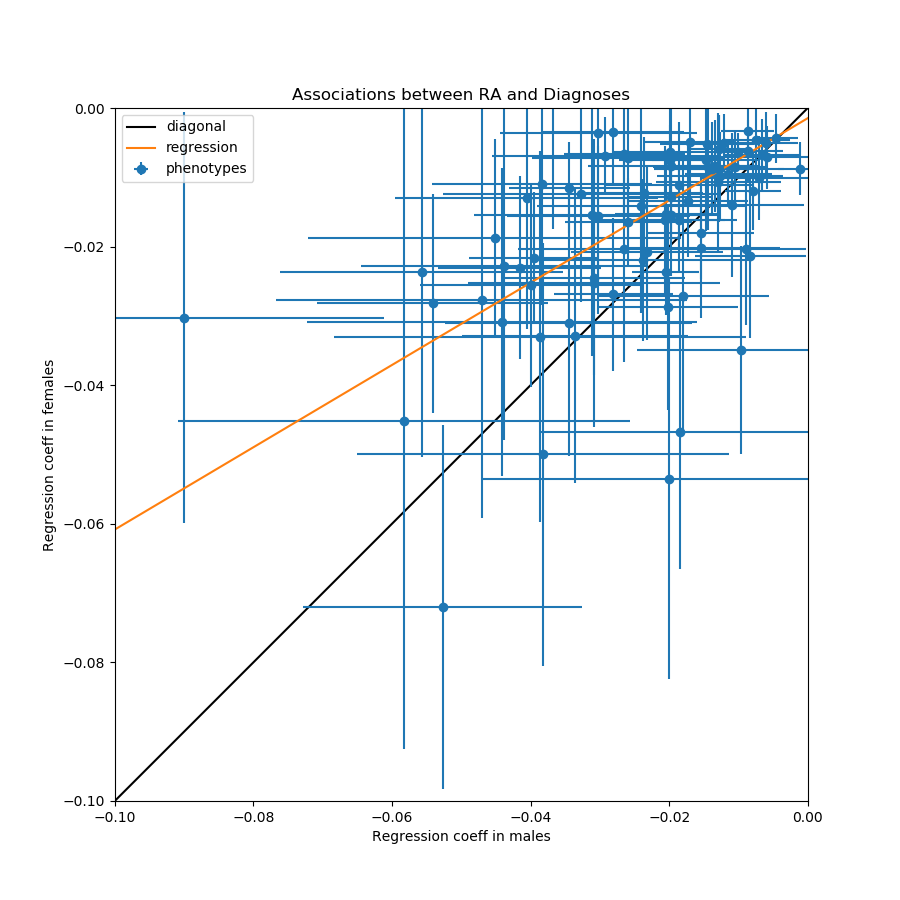

Beta: [-0.00146833  0.59363262]
Beta Std Error: [0.00121445 0.07526614]
Beta Covariance: [[3.15325051e-06 1.64282645e-04]
 [1.64282645e-04 1.21114994e-02]]
Residual Variance: 0.4677365805117117
Inverse Condition #: 0.08238269205185629
Reason(s) for Halting:
  Sum of squares convergence


In [27]:
# Plot the regression coefficients for each of the phenotypes
fig, ax = pylab.subplots(figsize=(9,9))
num_male = (phecode_ols_data.sex == "Male").sum()
num_female = (phecode_ols_data.sex == "Female").sum()

d = phecode_tests_by_sex[(phecode_tests_by_sex.q < 0.01)
                        & (phecode_tests_by_sex.N_male > 5)
                        & (phecode_tests_by_sex.N_female > 5)]
x = d["male_coeff"] # / (d["N_male"] / num_male)
y = d["female_coeff"] # / (d["N_female"] / num_female)
xerr = (d["male_coeff_high"] - d["male_coeff_low"])/2 #/ (d.N_male / num_male)
yerr = (d["female_coeff_high"] - d["female_coeff_low"])/2 #/ (d.N_female / num_female)
# The points
ax.errorbar(x = x,
            y =y,
            xerr = xerr,
            yerr = yerr,
            fmt = "o",
            label = "phenotypes")

# Diagonal y=x line
diag = numpy.array([ numpy.min([ax.get_xlim(), ax.get_ylim()]),
                    numpy.max([ax.get_xlim(), ax.get_ylim()]) ])
ax.plot(diag, diag, c='k', zorder=-1, label="diagonal")

# The regression line through the points
# Linear Deming/Orthogonal-distance regression since error in both variables
def deming(x, y, xerr, yerr):
    from scipy.odr import ODR, RealData, Model
    d = RealData(x,y, sy=yerr, sx=xerr)
    def linfit(args,x):
        return args[0] + args[1]*x
    est = [0,1]
    m = Model(linfit)
    odr = ODR(d, m, beta0=est).run()
    odr.pprint()
    return odr
odr = deming(x,
       y,
       xerr,
       yerr,
      )
intercept, coeff = odr.beta
ax.plot(diag, diag * coeff + intercept, label="regression")

ax.set_title("Associations between RA and Diagnoses")
ax.set_xlabel("Regression coeff in males")
ax.set_ylabel("Regression coeff in females")
ax.set_xlim(-0.1, 0.0)
ax.set_ylim(-0.1, 0.0)
ax.set_aspect("equal")
ax.legend()

fig.savefig(f"{OUTDIR}/sex_differences.all_phenotypes.png")

In [28]:
def local_regression(x,y, out_x, bw=0.05):
    # Preform a local regression y ~ x and evaluate it at the provided points `out_x`
    reg = sm.nonparametric.KernelReg(exog=x, endog=y, var_type='c',
                                     bw=[bw],
                                    )
    fit, mfx = reg.fit(out_x)
    return fit

<IPython.core.display.Javascript object>


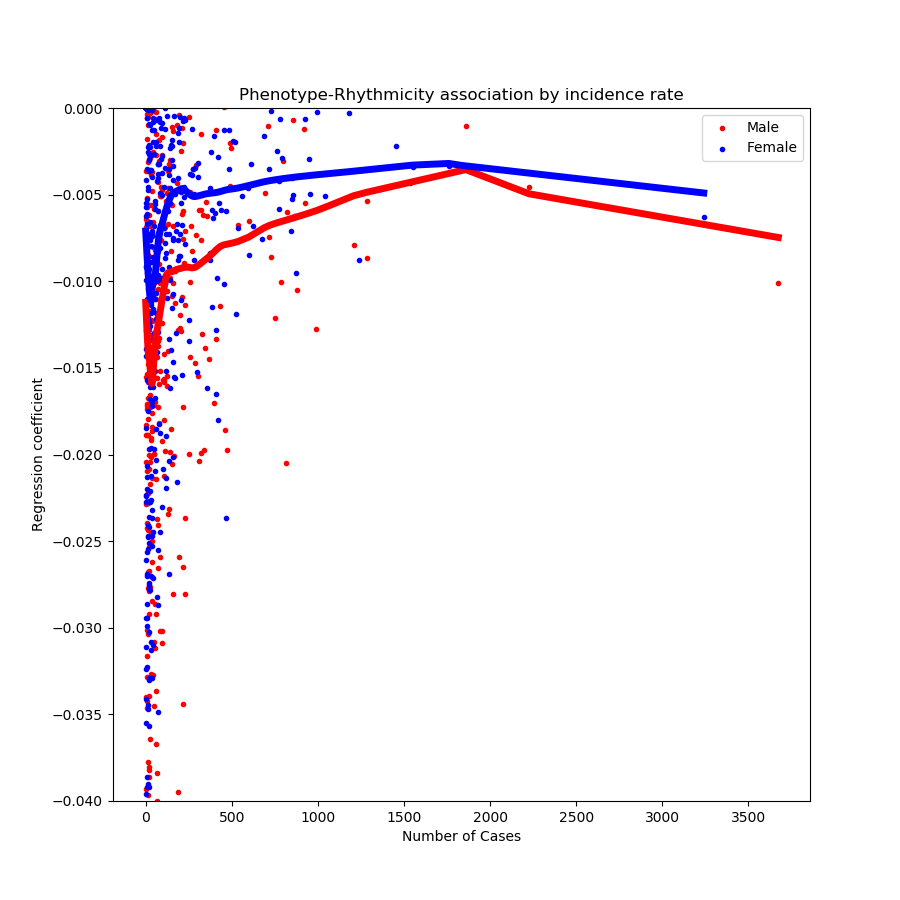

In [29]:
# Plot disease-incidence rates versus the coefficients, in both male and female

fig, ax = pylab.subplots( figsize=(9,9) )

ax.scatter(phecode_tests_by_sex.N_male, phecode_tests_by_sex.male_coeff, c="r", label="Male", marker='.')
ax.scatter(phecode_tests_by_sex.N_female, phecode_tests_by_sex.female_coeff, c="b", label="Female", marker='.')

for i in range(1):
    if i > 0:
        d = phecode_tests_by_sex.sample(len(phecode_tests_by_sex),replace=True)
    else:
        d = phecode_tests_by_sex
    
    male_smooth = sm.nonparametric.lowess(
                        d.male_coeff,
                        d.N_male,
                        return_sorted=True,
                        frac=0.6,
                        it=0)
    ax.plot(male_smooth[:,0], male_smooth[:,1], c="r", alpha=1, linewidth=5)
    female_smooth = sm.nonparametric.lowess(
                        d.female_coeff,
                        d.N_female,
                        return_sorted=True,
                        frac=0.6,
                        it=0)
    ax.plot(female_smooth[:,0], female_smooth[:,1], c="b", alpha=1, linewidth=5)
    
    '''
    eval_x = numpy.linspace(0, max(phecode_tests_by_sex.N_male.max(), phecode_tests_by_sex.N_female.max()), 51)
    male_smooth = local_regression(d.N_male,
                                   d.male_coeff,
                                   eval_x,
                                   bw=100)
    female_smooth = local_regression(d.N_female,
                                     d.female_coeff,
                                     eval_x,
                                     bw=100)
    
    ax.plot(eval_x, male_smooth, c="r", alpha=0.5)
    ax.plot(eval_x, female_smooth, c="b", alpha=0.5)
    '''

ax.legend()
ax.set_xlabel("Number of Cases")
ax.set_ylabel("Regression coefficient")
ax.set_title("Phenotype-Rhythmicity association by incidence rate")
ax.set_ylim(-0.04,0.00)

fig.savefig(OUTDIR+"/RA.all_phenotypes.by_incidence_rate.png")

### Check the overall average of effect size by sex of the RA-phenotype associations

In [30]:
male_weights = 1 / (phecode_tests_by_sex.male_coeff_high - phecode_tests_by_sex.male_coeff_low)**2 * (phecode_tests_by_sex.male_coeff != 0.0)
female_weights = 1 / (phecode_tests_by_sex.female_coeff_high - phecode_tests_by_sex.female_coeff_low)**2 * (phecode_tests_by_sex.female_coeff != 0.0)
rel_male_coeff = phecode_tests_by_sex.male_coeff  * male_weights
rel_female_coeff = phecode_tests_by_sex.female_coeff * female_weights

print(f"Weighted mean male effect:   {rel_male_coeff.mean() / male_weights.mean():0.4f}")
print(f"Median male effect:          {phecode_tests_by_sex.male_coeff.median():0.4f}")
print(f"Weighted mean female effect: {rel_female_coeff.mean() / male_weights.mean():0.4f}")
print(f"Median female effect:        {phecode_tests_by_sex.female_coeff.median():0.4f}")
print(f"Note: effects are the difference in mean RA values between cases and controls of the phenotype.")
print(f"   standard deviation of RA:  {data.acceleration_RA.std():0.4f}")

Weighted mean male effect:   -0.0085
Median male effect:          -0.0068
Weighted mean female effect: -0.0063
Median female effect:        -0.0053
Note: effects are the difference in mean RA values between cases and controls of the phenotype.
   standard deviation of RA:  0.0683


In [31]:
phecode_tests_by_sex.to_csv(OUTDIR+"/RA.all_phenotypes.by_sex.txt", sep="\t")
phecode_tests_by_sex.sort_values(by="p_diff")

,male_coeff,female_coeff,p_male,p_female,p_diff,N_male,N_female,male_coeff_low,male_coeff_high,female_coeff_low,female_coeff_high,meaning,category,q,q_diff
910,-0.599576,0.039382,6.700256e-21,0.537480,1.545970e-12,1.0,1.0,-0.724773,-0.474378,-0.085798,0.164561,"Superficial injury, infected",injuries & poisonings,2.169613e-08,8.487375e-10
230,-0.283056,0.000000,9.808270e-06,NaN,9.808270e-06,1.0,0.0,-0.408514,-0.157599,0.000000,0.000000,Kaposi's sarcoma,neoplasms,1.223805e-04,2.692370e-03
563,-0.034419,-0.011494,1.215108e-14,0.000599,3.945931e-05,218.0,383.0,-0.043159,-0.025679,-0.018057,-0.004931,Constipation,digestive,1.449079e-11,7.221054e-03
474,-0.023421,0.004229,3.674577e-05,0.357483,1.530238e-04,132.0,197.0,-0.034542,-0.012300,-0.004779,0.013238,Acute and chronic tonsillitis,respiratory,1.592542e-01,1.771361e-02
198,-0.028062,-0.003505,6.554020e-08,0.371566,1.613262e-04,157.0,274.0,-0.038239,-0.017885,-0.011195,0.004184,Secondary malignant neoplasm,neoplasms,7.067332e-04,1.771361e-02
976,0.069855,-0.201712,2.757019e-01,0.000008,5.383308e-04,1.0,2.0,-0.055754,0.195464,-0.290428,-0.112997,Poisoning by agents primarily affecting skin &...,injuries & poisonings,1.507944e-02,4.763715e-02
694,-0.041338,0.009338,1.427893e-04,0.351744,6.110810e-04,36.0,41.0,-0.062638,-0.020037,-0.010317,0.028993,Dyschromia and Vitiligo,dermatologic,1.569141e-01,4.763715e-02
696,0.007602,-0.015612,1.089412e-01,0.001556,6.941661e-04,188.0,172.0,-0.001693,0.016897,-0.025282,-0.005942,Psoriasis and related disorders,dermatologic,5.090401e-01,4.763715e-02
740,0.005816,-0.003325,6.287539e-03,0.050125,7.866878e-04,1059.0,1761.0,0.001644,0.009987,-0.006653,0.000002,Osteoarthrosis,musculoskeletal,9.305529e-01,4.798795e-02
655,0.000000,0.011141,NaN,0.001939,1.938985e-03,0.0,353.0,0.000000,0.000000,0.004096,0.018186,Known or suspected fetal abnormality affecting...,pregnancy complications,1.169783e-02,1.019644e-01


In [32]:
# Plot phecode incidence versus a variable
MALE_COLOR = "b"
FEMALE_COLOR = "r"
def plot_phecode_incidence(code, normalize_sexes=False, yscale="all"):
    # if yscale = 'auto' then it will fit to the data, if 'all' then it uses 0-1 as range
    fig, ax = pylab.subplots()
    male_max = None
    male_min = None
    female_max = None
    female_min = None
    eval_x = numpy.linspace(0.5,1.0, 21)
    
    for i in range(20):
        d = phecode_ols_data.sample(frac=1, replace=True)
        d_male = d[d.sex == "Male"]
        d_female = d[d.sex == "Female"]

        if normalize_sexes:    
            # Downsample to equal percent of cases in both male and female
            # so that the differences between sexes are more visible
            p_male = d_male[code].sum() / len(d_male)
            p_female = d_female[code].sum() / len(d_female)
            down_to = min(p_male, p_female)
            if p_male > p_female:
                to_keep = numpy.random.choice(numpy.where(d_male[code].astype(bool))[0],
                                              replace=False,
                                              size=int(down_to*len(d_male)))
                control = numpy.where(~d_male[code].astype(bool))[0]
                d_male = d_male.iloc[numpy.concatenate((to_keep, control))]
            else:
                to_keep = numpy.random.choice(numpy.where(d_female[code].astype(bool))[0],
                                              replace=False,
                                              size=int(down_to*len(d_female)))
                control = numpy.where(~d_female[code].astype(bool))[0]
                d_female = d_female.iloc[numpy.concatenate((to_keep, control))]

        s = local_regression(d_male['acceleration_RA'], d_male[code], eval_x)

        if male_max is None:
            male_max = s
        else:
            male_max = numpy.maximum(male_max, s)
        if male_min is None:
            male_min = s
        else:
            male_min = numpy.minimum(male_min, s)
            
        s = local_regression(d_female['acceleration_RA'], d_female[code], eval_x)

        if female_max is None:
            female_max = s
        else:
            female_max = numpy.maximum(female_max, s)
        if female_min is None:
            female_min = s
        else:
            female_min = numpy.minimum(female_min, s)
            
    # Draw the confidence interval
    ax.fill_between(eval_x, male_min, male_max, color=MALE_COLOR, alpha=0.5)
    ax.fill_between(eval_x, female_min, female_max, color=FEMALE_COLOR, alpha=0.5)
            
    d_male = phecode_ols_data[phecode_ols_data.sex == "Male"]
    s_male = local_regression(d_male['acceleration_RA'], d_male[code], eval_x)

                
    ax.plot(eval_x, s_male, c=MALE_COLOR)
    
    d_female = phecode_ols_data[phecode_ols_data.sex == "Female"]
    s_female = local_regression(d_female['acceleration_RA'], d_female[code], eval_x)

    ax.plot(eval_x, s_female, c=FEMALE_COLOR)

    if yscale == 'all':
        ax.set_ylim(0,1)
    elif yscale == "auto":
        if max(numpy.max(s_male), numpy.max(s_female)) > 0.1:
            # If prevelant enough, show the whole range
            # but some are too rare too see, so we use the default zoom
            ax.set_ylim(top=1)
        ax.set_ylim(bottom=0)
    ax.set_ylabel(f"Incidence rate")
    ax.set_xlabel("RA")
    ax.legend(handles=[mpatches.Patch(facecolor=MALE_COLOR, label="Male"),
                       mpatches.Patch(facecolor=FEMALE_COLOR, label="Female")])
    ax.set_title(phecode_tests.meaning[code])
    return fig

<IPython.core.display.Javascript object>


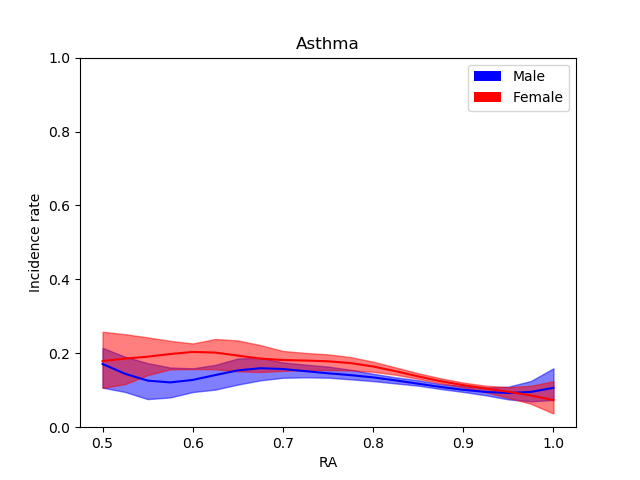

In [33]:
fig = plot_phecode_incidence(495, normalize_sexes = False)

In [34]:
# Generate and save plots for a variety of phecodes
phecodes = [480, 495] + list(phecode_tests.sort_values(by="p").index[:20])
pylab.ioff()
for phecode in phecodes:
    fig = plot_phecode_incidence(phecode, yscale="auto")
    fig.savefig(OUTDIR + f"{phecode}.incidence.png")
    pylab.close()
pylab.ion()

<IPython.core.display.Javascript object>


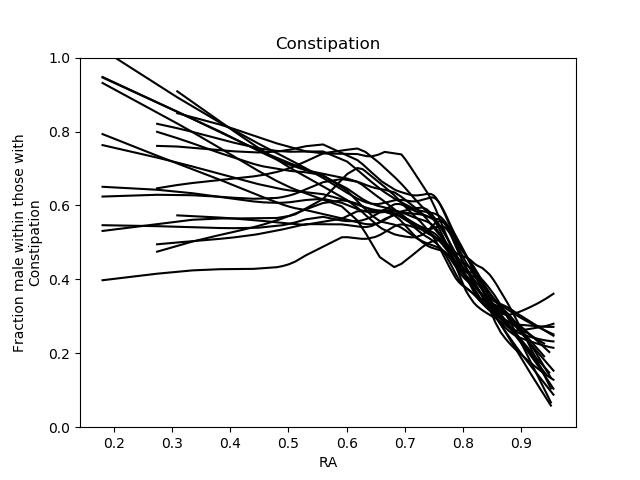

Text(0.5, 1.0, 'Constipation')

In [35]:
# Compare RATIO of the prevelance of the two sexes within cases, as a function of RA score
group = 563
fig, ax = pylab.subplots()
for i in range(20):
    d = phecode_ols_data[phecode_ols_data[group] == 1].sample(frac=1, replace=True)

    s = sm.nonparametric.lowess(d.sex == "Male",
                                  d['acceleration_RA'],
                                  return_sorted=True,
                                   frac=0.8,
                                  delta=0.005,
                                  it=0)
    ax.plot(s[:,0], s[:,1], c="k")
ax.set_ylim(0,1)
ax.set_ylabel(f"Fraction male within those with\n{phecode_tests.meaning[group]}")
ax.set_xlabel("RA")
ax.set_title(phecode_tests.meaning[group])

## Test age interactions with the RA-phenotype association

In [36]:
# Correlate each block-level code with our activity variable within age buckets
age_buckets = range(int(phecode_ols_data.birth_year.min()), int(phecode_ols_data.birth_year.max()+1), 10)
def to_age_bucket(birth_year):
    i = numpy.searchsorted(age_buckets, birth_year)
    return f"{age_buckets[i-1]}-{age_buckets[i-1]+10}"
phecode_ols_data['age_bucket'] = phecode_ols_data.birth_year.map(to_age_bucket)

activity_variable = "acceleration_RA"

phecode_tests_by_age = {}

covariate_formula = ' + '.join(c for c in covariates if c != 'sex')


for group in phecode_groups:  
    N = phecode_ols_data[group].sum()
    if N <= 0:
        print(f"Skipping {group} - only {N} cases found")
        continue
        
    if phecode_tests.loc[group, "q"] > 0.01:
        # Skip test, not significant
        #print(f"Skipping {group} since q > 0.01")
        continue
        
    fit = smf.ols(f"acceleration_RA ~ 0 + (age_bucket) : (sex +  Q({group})) + BMI",
                     data=phecode_ols_data).fit()
    restricted_fit = smf.ols(f"acceleration_RA ~ 0 + (age_bucket + sex +  Q({group}))  + BMI",
                     data=phecode_ols_data).fit()

    f,p,df = fit.compare_f_test(restricted_fit)
    conf_ints = fit.conf_int()
    #male_conf_int = conf_ints.loc[f'C(sex, Treatment(reference=-1))[Male]:Q({group})']
    #female_conf_int = conf_ints.loc[f'C(sex, Treatment(reference=-1))[Female]:Q({group})']
    
    phecode_tests_by_age[group] = {
        "N": N,
        "p": p,
    }

phecode_tests_by_age = pandas.DataFrame(phecode_tests_by_age).T

Skipping 31 - only 0.0 cases found
Skipping 1003 - only 0.0 cases found
Skipping 196 - only 0.0 cases found
Skipping 209 - only 0.0 cases found
Skipping 249 - only 0.0 cases found
Skipping 254 - only 0.0 cases found
Skipping 264 - only 0.0 cases found
Skipping 453 - only 0.0 cases found
Skipping 498 - only 0.0 cases found
Skipping 637 - only 0.0 cases found
Skipping 657 - only 0.0 cases found
Skipping 658 - only 0.0 cases found
Skipping 712 - only 0.0 cases found
Skipping 763 - only 0.0 cases found
Skipping 767 - only 0.0 cases found
Skipping 769 - only 0.0 cases found
Skipping 795 - only 0.0 cases found
Skipping 796 - only 0.0 cases found
Skipping 799 - only 0.0 cases found
Skipping 816 - only 0.0 cases found
Skipping 823 - only 0.0 cases found
Skipping 855 - only 0.0 cases found
Skipping 856 - only 0.0 cases found
Skipping 875 - only 0.0 cases found
Skipping 876 - only 0.0 cases found
Skipping 905 - only 0.0 cases found
Skipping 906 - only 0.0 cases found
Skipping 908 - only 0.0 case

In [37]:
phecode_tests_by_age['q'] = BH_FDR(phecode_tests_by_age.p)
phecode_tests_by_age["meaning"] = phecode_tests_by_age.index.map(phecode_info.phenotype)
phecode_tests_by_age["category"] = phecode_tests_by_age.index.map(phecode_info.category)
print("Age-effect of RA-phenotype interactions")
phecode_tests_by_age.sort_values("p")

Age-effect of RA-phenotype interactions


,N,p,q,meaning,category
910,2.0,1.520066e-10,1.337658e-08,"Superficial injury, infected",injuries & poisonings
502,40.0,3.386753e-08,1.490171e-06,Postinflammatory pulmonary fibrosis,respiratory
301,16.0,1.590618e-05,4.665812e-04,Personality disorders,mental disorders
441,41.0,1.919050e-04,4.221909e-03,Vascular insufficiency of intestine,circulatory system
994,138.0,2.827130e-04,4.410600e-03,Sepsis and SIRS,injuries & poisonings
442,106.0,3.007227e-04,4.410600e-03,Other aneurysm,circulatory system
317,676.0,4.087237e-04,5.138241e-03,Alcohol-related disorders,mental disorders
327,384.0,1.344215e-03,1.478637e-02,Sleep disorders,neurological
458,295.0,3.380119e-03,3.005772e-02,Hypotension,circulatory system
38,177.0,3.415651e-03,3.005772e-02,Septicemia,infectious diseases


In [38]:
# Phecode incidence plots by age buckets
decades = range(int(phecode_ols_data.birth_year.min()), int(phecode_ols_data.birth_year.max()+1), 10)
def plot_phecode_incidence_by_age(data, code, yscale="all", ax = None,  c="k"):
    # if yscale = 'auto' then it will fit to the data, if 'all' then it uses 0-1 as range
    if not ax:
        fig, ax = pylab.subplots()
    eval_x = numpy.linspace(0.5,1.0, 21)
    
    peak = 0
    values = numpy.linspace(0.3, 1.0, len(decades))
    for i, decade in enumerate(decades):
        in_decade = (data.birth_year >= decade) & (data.birth_year < decade + 10)
        d = data[in_decade]
        
        smoothed = local_regression(d['acceleration_RA'], d[code], eval_x, bw=0.1)
        
        ax.plot(eval_x, smoothed, c = c, alpha=values[i])
        peak = max(numpy.max(smoothed), peak)
        
    if yscale == 'all':
        ax.set_ylim(0,1)
    elif yscale == "auto":
        if peak > 0.1:
            # If prevelant enough, show the whole range
            # but some are too rare too see, so we use the default zoom
            ax.set_ylim(top=1)
        ax.set_ylim(bottom=0)
        
    ax.set_ylabel(f"Incidence rate")
    ax.set_xlabel("RA")
    ax.legend(handles=[mpatches.Patch(facecolor='k', alpha=val, label=f"{decade}-{decade+9}")
                       for val,decade in zip(values, decades)])
    ax.set_title(phecode_tests.meaning[code])
    return ax.get_figure()

<IPython.core.display.Javascript object>


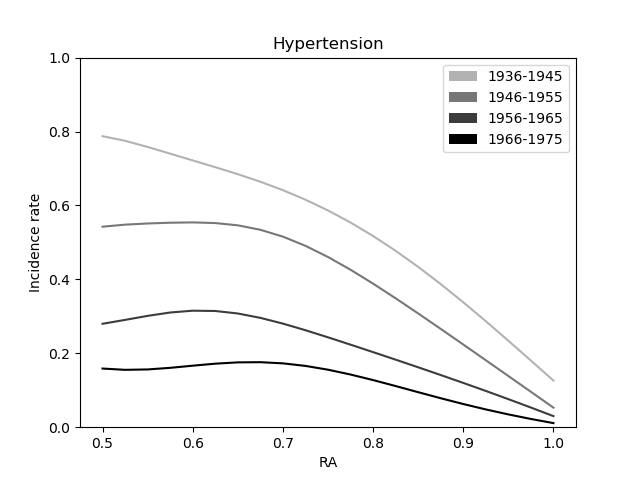

In [39]:
fig = plot_phecode_incidence_by_age(phecode_ols_data, 401, yscale='auto')

<IPython.core.display.Javascript object>


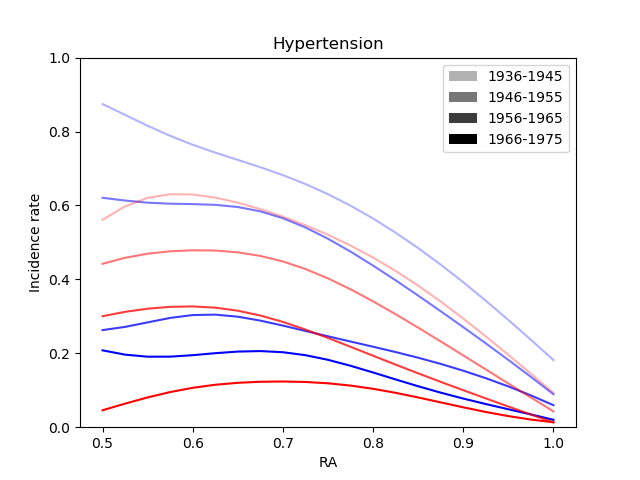

In [40]:
fig = plot_phecode_incidence_by_age(phecode_ols_data[phecode_ols_data['sex'] == "Male"], 401, yscale='auto', c="b")
plot_phecode_incidence_by_age(phecode_ols_data[phecode_ols_data['sex'] == "Female"], 401, yscale='auto', ax = fig.gca(), c="r")
fig.savefig(OUTDIR+"401.incidence.by_age_and_sex.png")

In [41]:
# Generate and save by-age plots for a variety of phecodes
phecodes = [480, 495] + list(phecode_tests.sort_values(by="p").index[:20])
pylab.ioff()
for phecode in phecodes:
    fig = plot_phecode_incidence_by_age(phecode_ols_data, phecode, yscale="auto")
    fig.savefig(OUTDIR + f"{phecode}.incidence.by_age.png")
    pylab.close()
pylab.ion()

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


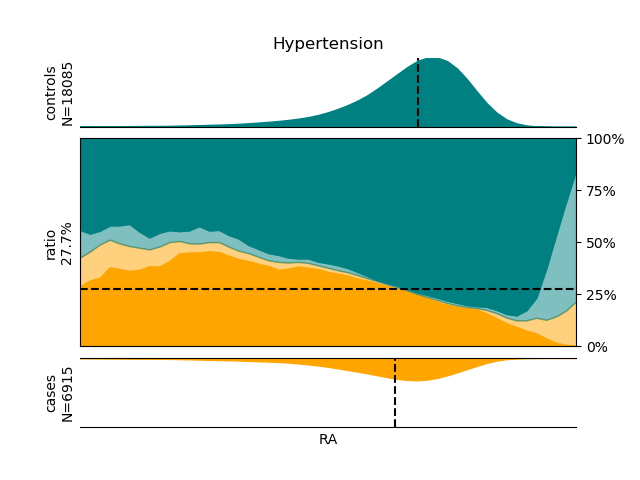

In [171]:
# Fancy style plot
# Only really works for highly abundant phenotypes like hypertension (401)
def fancy_case_control_plot(data, code, var="acceleration_RA", normalize=False, confidence_interval=False):
    CONTROL_COLOR = "teal"
    CASE_COLOR = "orange"
    UNCERTAIN_COLOR = (0.8, 0.8, 0.8)

    case = data[code] == True

    point_width = 0.01
    xbottom = 0.6
    xtop = 1.0
    eval_x = numpy.linspace(xbottom, xtop, 0.5/point_width + 1)

    case_scaling = (case).sum() * point_width
    control_scaling = (~case).sum() * point_width

    case_avg = data[var][case].median()
    control_avg = data[var][~case].median()

    
    total_incidence = case.sum()/len(case)
    
    def densities_and_incidence(data):
        case_density = scipy.stats.gaussian_kde(data[var][case], bw_method=0.15)(eval_x) * case_scaling
        control_density = scipy.stats.gaussian_kde(data[var][~case], bw_method=0.15)(eval_x) * control_scaling
        if not normalize:
            #incidence = local_regression(data[var], data[code], eval_x, bw=0.1)
            incidence = case_density / (control_density  + case_density)
        if normalize:
            incidence = case_density / total_incidence / 2 / (control_density + case_density / total_incidence / 2)
        return case_density, control_density, incidence
    
    case_density, control_density, incidence = densities_and_incidence(data)
            
    if confidence_interval:
        N = 40
        incidences = numpy.empty((len(eval_x), N))
        for i in range(N):
            sample = data.sample(len(data), replace=True)
            _, _, incidence = densities_and_incidence(sample)
            incidences[:,i] = incidence
        incidences = numpy.sort(incidences, axis=1)
        lower_bound = incidences[:,0]
        upper_bound = incidences[:,-1]
        middle = incidences[:,incidences.shape[1]//2]

    fig, (ax1,ax2,ax3) = pylab.subplots(nrows=3, sharex=True,
                                        gridspec_kw = {"hspace":0.1,
                                                       "height_ratios":[0.2,0.6,0.2]})

    # Plot the data
    ax1.fill_between(eval_x, 0, control_density, color=CONTROL_COLOR)
    if confidence_interval:
        ax2.fill_between(eval_x, 0, lower_bound, color=CASE_COLOR)
        ax2.fill_between(eval_x, lower_bound, middle, color=CASE_COLOR, alpha=0.5)
        ax2.fill_between(eval_x, middle, upper_bound, color=CONTROL_COLOR, alpha=0.5)
        ax2.fill_between(eval_x, upper_bound, 1, color=CONTROL_COLOR)
        #ax2.fill_between(eval_x, lower_bound, upper_bound, color=UNCERTAIN_COLOR)
    else:
        ax2.fill_between(eval_x, 0, incidence, color=CASE_COLOR)
        ax2.fill_between(eval_x, incidence, 1, color=CONTROL_COLOR)
    ax3.fill_between(eval_x, 0, case_density, color=CASE_COLOR)

    # Plot avgs
    ax1.axvline(control_avg, c='k', linestyle="--")
    ax3.axvline(case_avg, c='k', linestyle="--")
    ax2.axhline(total_incidence, c='k', linestyle="--")

    # Label plot
    ax1.set_ylabel(f"controls\nN={(~case).sum()}")
    ax2.set_ylabel(f"ratio\n{total_incidence:0.1%}")
    ax3.set_ylabel(f"cases\nN={case.sum()}") 
    ax3.set_xlabel("RA")

    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks([])
    ax1.yaxis.set_ticks([])
    ax2.xaxis.set_ticks_position('none')
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_ticks([0,0.25, 0.5, 0.75, 1])
    ax2.yaxis.set_ticklabels(["0%", "25%", "50%", "75%","100%"])
    ax3.spines['left'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.yaxis.set_ticks([])

    # Set axis limits
    ax1.set_xlim(xbottom, xtop)
    ax2.set_ylim(0, 1)
    if not normalize:
        max_density = max(numpy.max(case_density), numpy.max(control_density))
        ax1.set_ylim(0, max_density)
        ax3.set_ylim(0, max_density)
    else:
        ax1.set_ylim(0)
        ax3.set_ylim(0)
    ax3.invert_yaxis()

    try:
        ax1.set_title(phecode_tests.loc[code].meaning + ("\n(normalized)" if normalize else ""))
    except KeyError:
        ax1.set_title(code)
    return fig

fig = fancy_case_control_plot(phecode_ols_data, 401, normalize=False, confidence_interval=True)

In [43]:
fig.savefig(OUTDIR+"test.401.6.png")

In [44]:
phe306_codes = phecode_map[phecode_map.PHECODE == 306.00].index
for code in phe306_codes:
    print(code, (icd10_entries.ICD10 == code).sum())

F488 0
F54 0
F621 0
G210 0
Z046 0
Z864 1695
Z865 63


In [45]:
# Generate and save some of the 'fancy' plots
pylab.ioff()
phecodes = [480, 495] + list(phecode_tests.sort_values(by="p").index[:20])
for code in  phecodes:
    if phecode_ols_data[code].sum() < 20:
        continue
    fig = fancy_case_control_plot(phecode_ols_data, code, confidence_interval=True, normalize=True)
    fig.savefig(OUTDIR+f"{code}.fancy.plot.png")
    pylab.close()
pylab.ion()

# Hypertension analysis

In [46]:
ukbb.columns[ukbb.columns.str.contains('rate')]

Index(['urate', 'pulse_rate_V0', 'pulse_rate_V1'], dtype='object')

In [47]:
# Average all the BP readings
phecode_ols_data['systolic_bp'] = ukbb[['systolic_blood_pressure_V1',
                                        'systolic_blood_pressure_V0',
                                        'systolic_blood_pressure_manual_V0',
                                        'systolic_blood_pressure_manual_V1'
                                        ]].mean(axis=1)
phecode_ols_data['diastolic_bp'] = ukbb[['diastolic_blood_pressure_V1',
                            'diastolic_blood_pressure_V0',
                            'diastolic_blood_pressure_manual_V0',
                            'diastolic_blood_pressure_manual_V1']].mean(axis=1)
phecode_ols_data['pulse_rate'] = ukbb[[
                                    'pulse_rate_V0',
                                    'pulse_rate_V1'
                                    ]].mean(axis=1)
#phecode_ols_data = phecode_ols_data.join(ukbb[['systolic_bp', 'diastolic_bp']])

In [30]:
# Plot of the BP-RA relation
def weighted_quantile(series, weights, quantile):
    # Approximate weighted quantile
    ordering = numpy.argsort(series.values)
    cum_weights = numpy.cumsum(weights[ordering]) / weights.sum()
    q_idx = numpy.searchsorted(cum_weights, quantile)
    if q_idx >= len(ordering):
        # A 1.0 quantile is always technically past the end
        # so just give it the last value
        q_idx = len(ordering) -1 
    return series.iloc[ordering[q_idx]]

def plot_quantitative_var(data, var, ax = None,  c="k", nbins=5, scatter=False):
    quantiles = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
    
    xmin = 0.5

    if not ax:
        fig, ax = pylab.subplots()
    eval_x = numpy.linspace(xmin, 1.0, 21)
    
    
    if scatter:
        ax.scatter(data['acceleration_RA'].values, data[var].values, s = 1, marker='.')
    
    alpha_values = numpy.linspace(0.3, 1.0, len(quantiles))
    for i, quantile in enumerate(quantiles):
        smoothed = numpy.empty(len(eval_x))
        for j, x in enumerate(eval_x):
            
            weights = numpy.exp(-(data['acceleration_RA'].values - x)**2 / 0.02)
            smoothed[j] = weighted_quantile(data[var], weights, quantile)

        ax.plot(eval_x, smoothed, c = c, alpha=alpha_values[i])
    
    #ax.axhline(data[var].median(), c="r")
        
    '''
    means = numpy.empty(len(eval_x))
    for j, x in enumerate(eval_x):
        weights = numpy.exp(-(data['acceleration_RA'].values - x)**2 / 0.02)
        means[j] = (data[var] * weights).sum() / weights.sum()
    ax.plot(eval_x, means, c="r")
    '''
        
    ax.set_ylabel(var)
    ax.set_xlabel("RA")
    ax.set_xlim(min(eval_x), max(eval_x))
    ax.legend(handles=[mpatches.Patch(facecolor='k', alpha=val, label=f"{quantile:0.0%}")
                       for val,(quantile) in zip(alpha_values, quantiles)])
    ax.set_title(f"{var} quantiles by RA")
    return ax.get_figure()

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


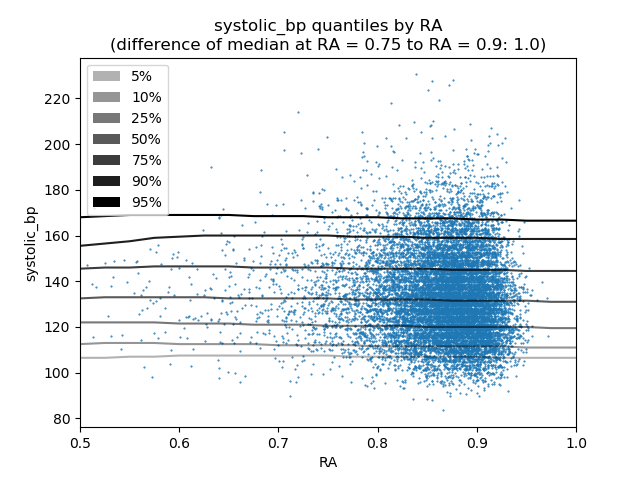

In [173]:
fig, _ = plot_quantitative_var(phecode_ols_data[phecode_ols_data.sex == "Female"], 'systolic_bp', scatter=True)
fig.savefig("systolic_bp.png")

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


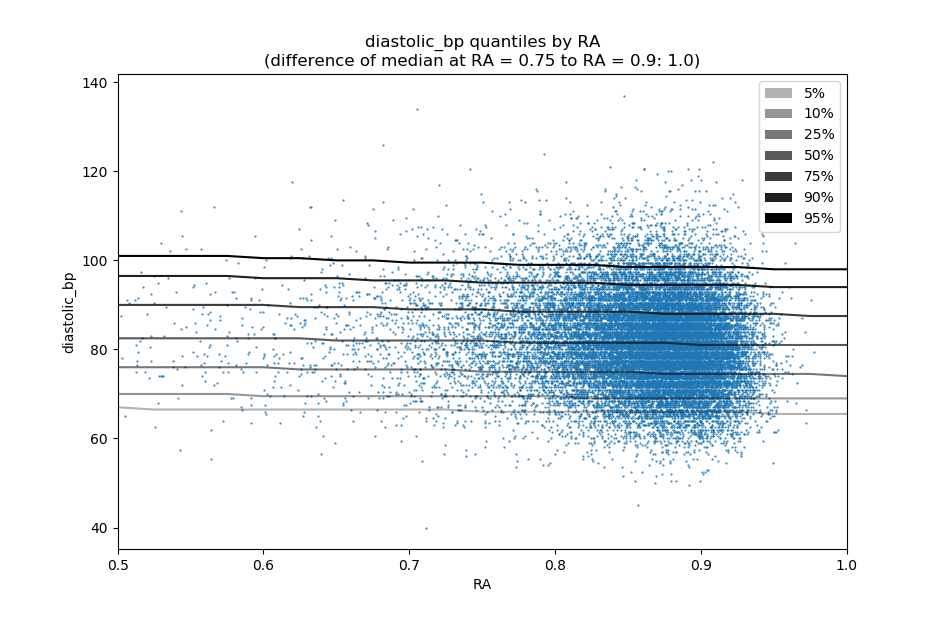

In [169]:
fig,_ = plot_quantitative_var(phecode_ols_data, 'diastolic_bp', scatter=True)
fig.savefig(OUTDIR+"diastolic_bp.png")

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


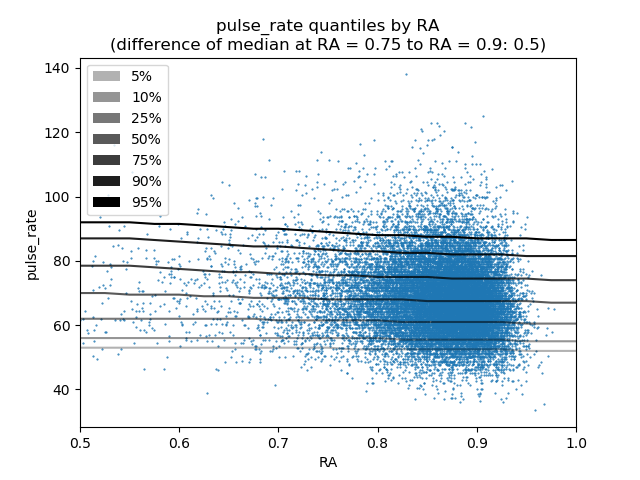

In [170]:
fig,_ = plot_quantitative_var(phecode_ols_data, 'pulse_rate', scatter=True)
fig.savefig(OUTDIR+"pulse_rate.png")

## Medications

In [52]:
# Load the medications list
medications = pandas.read_csv("../processed/ukbb_medications.txt", sep="\t", dtype={'medication_code': "int"})
medications.medication_code = medications.medication_code.astype(str)
MEDICATIONS_CODING = 4
med_code_to_name = codings[codings.Coding == MEDICATIONS_CODING].set_index("Value").Meaning
medications['medication'] = pandas.Series(medications.medication_code.map(med_code_to_name), dtype="category")

In [53]:
# Load the list of hypertension-related drugs
hypertension_medications = pandas.read_csv("../hypertension_medications.txt", sep="\t")
hypertension_medications.Drug = hypertension_medications.Drug.str.lower()

In [54]:
on_hypertensive_medication = medications.groupby("ID").medication.apply(lambda x: any(x.isin(hypertension_medications.Drug)))

In [55]:
phecode_ols_data['on_hypertensive_medication'] = on_hypertensive_medication
phecode_ols_data.on_hypertensive_medication.fillna(False, inplace=True)
phecode_ols_data['hypertensive_and_medication'] = (phecode_ols_data.on_hypertensive_medication & phecode_ols_data[401])
phecode_ols_data['hypertensive_no_medication'] = (~phecode_ols_data.on_hypertensive_medication) & phecode_ols_data[401]

<IPython.core.display.Javascript object>


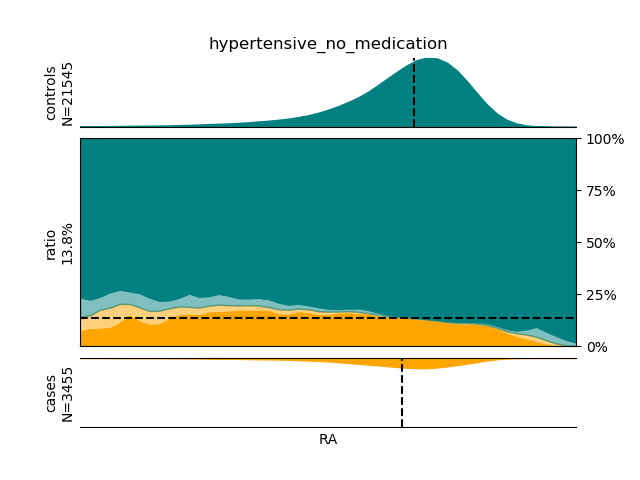

In [56]:
fig = fancy_case_control_plot(phecode_ols_data,
                        'hypertensive_no_medication', confidence_interval=True)
fig.savefig(OUTDIR+"hypertensive_no_medication.png")

<IPython.core.display.Javascript object>


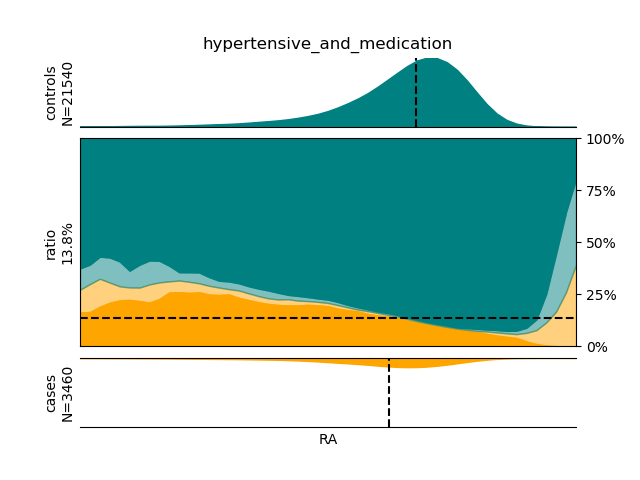

In [57]:
fig = fancy_case_control_plot(phecode_ols_data,
                        'hypertensive_and_medication', confidence_interval=True)
fig.savefig(OUTDIR+"hypertensive_and_medication.png")

<IPython.core.display.Javascript object>


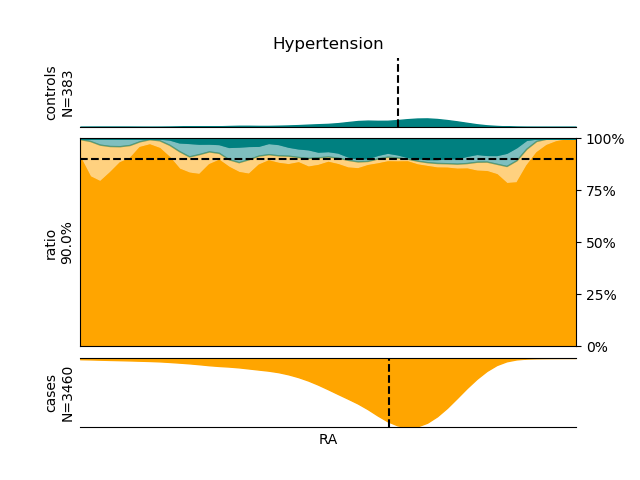

In [58]:
fig = fancy_case_control_plot(phecode_ols_data[phecode_ols_data.on_hypertensive_medication == True],
                        401, confidence_interval=True)

<IPython.core.display.Javascript object>


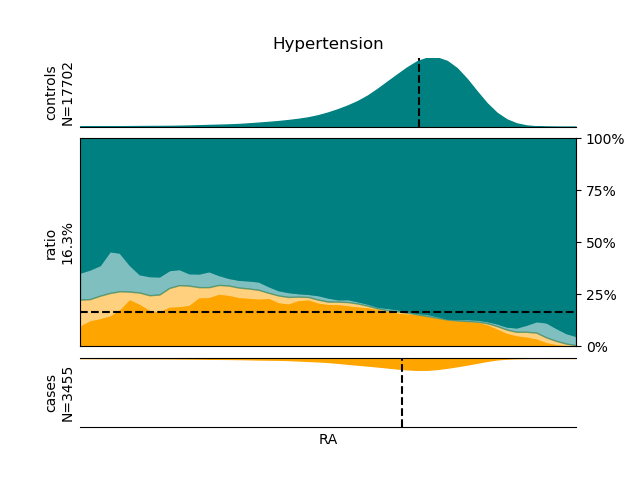

In [59]:
fig = fancy_case_control_plot(phecode_ols_data[phecode_ols_data.on_hypertensive_medication == False],
                        401, confidence_interval=True)

<IPython.core.display.Javascript object>


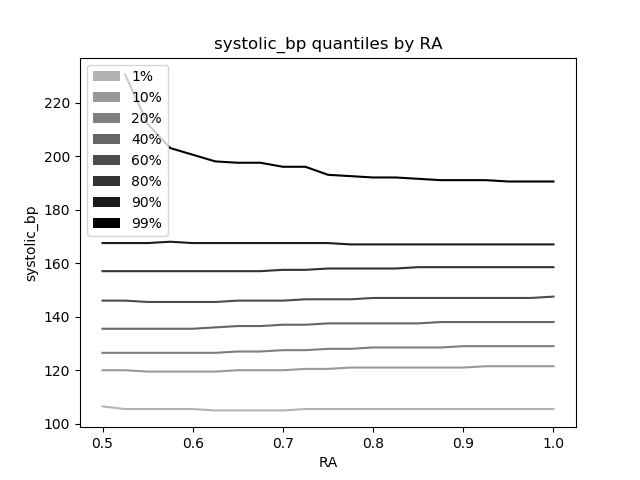

In [60]:
fig = plot_quantitative_var(phecode_ols_data[phecode_ols_data.on_hypertensive_medication == True],
                        "systolic_bp")
fig.savefig(OUTDIR+"systolic_bp.on_hypertensive_medication.png")

<IPython.core.display.Javascript object>


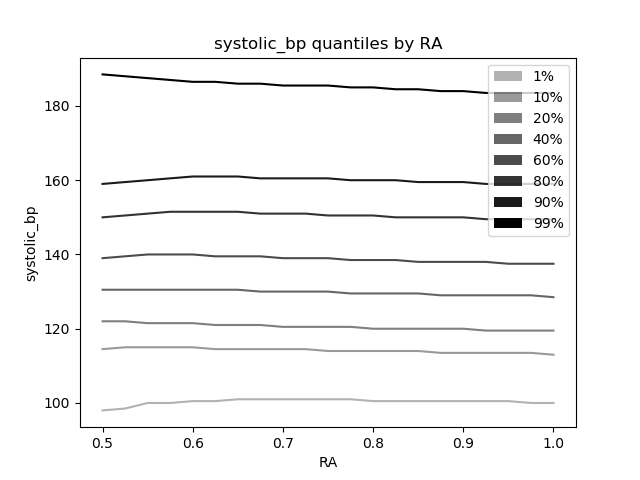

In [61]:
fig = plot_quantitative_var(phecode_ols_data[phecode_ols_data.on_hypertensive_medication == False],
                        "systolic_bp")
fig.savefig(OUTDIR+"systolic_bp.no_hypertensive_medication.png")

In [39]:
d = data.join(ukbb.drop(columns=data.columns.intersection(ukbb.columns)), how="left")

<IPython.core.display.Javascript object>

KeyError: 'neutrophil_percent'

<IPython.core.display.Javascript object>


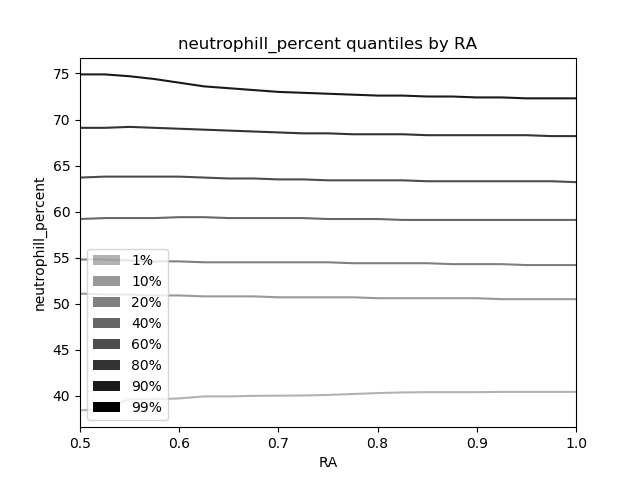

In [52]:
fig = plot_quantitative_var(d, "neutrophill_percent")
fig.savefig(OUTDIR+"neutrophil_percent.by_RA.png")

<IPython.core.display.Javascript object>


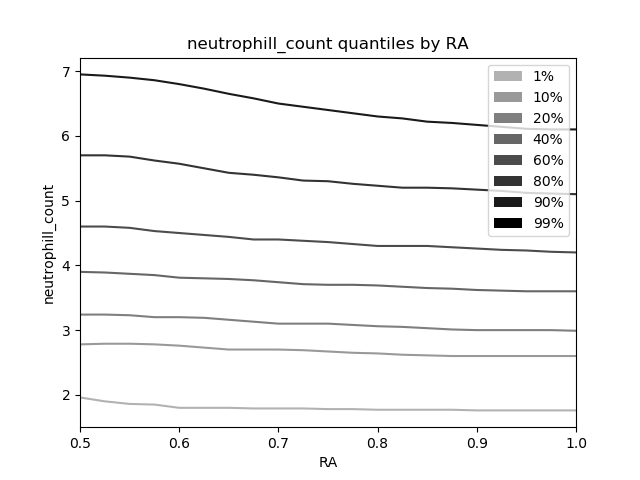

In [53]:
fig = plot_quantitative_var(d, "neutrophill_count")
fig.savefig(OUTDIR+"neutrophil_count.by_RA.png")

<IPython.core.display.Javascript object>


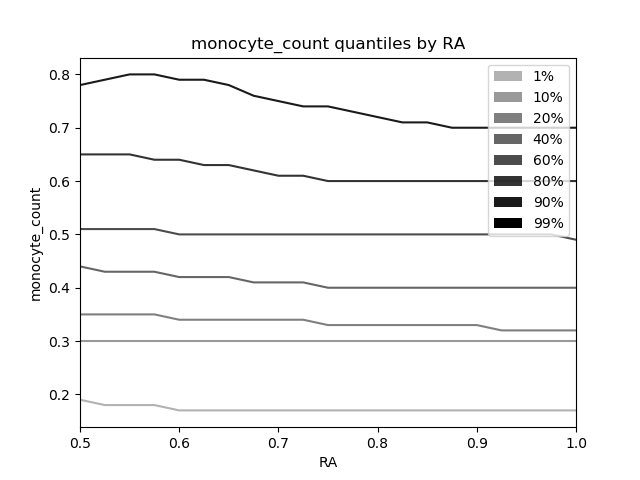

In [54]:
fig = plot_quantitative_var(d, "monocyte_count")
fig.savefig(OUTDIR+"neutrophil_count.by_RA.png")

<IPython.core.display.Javascript object>


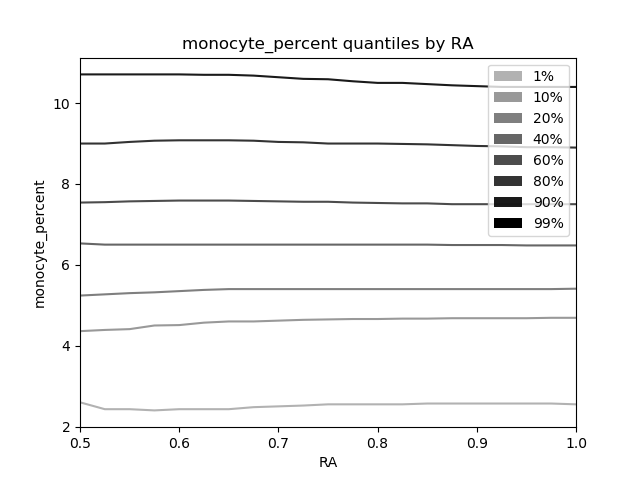

In [55]:
fig = plot_quantitative_var(d, "monocyte_percent")
fig.savefig(OUTDIR+"neutrophil_percent.by_RA.png")

In [63]:
icd10_entries[icd10_entries.ICD10.str.contains("I70")]

,ID,ICD10,first_date
179999,1216367,I7020,2012-09-23
278491,1336607,I7020,2016-05-26
330772,1400666,I702,2001-05-13
343438,1417065,I7020,2013-06-07
365166,1443014,I7020,2016-09-15
515053,1624866,I709,1997-04-16
607853,1736888,I7010,2016-05-15
704068,1853985,I702,2011-07-04
792630,1963176,I700,2010-11-07
1041198,2266474,I702,2003-12-11
